# National Accessibility Case Study

### Project Brief

Congratulations, you have landed your first job as a data scientist at National Accessibility! National Accessibility currently installs wheelchair ramps for office buildings and schools. However, the marketing manager wants the company to start installing ramps for event venues as well. According to a new survey, approximately 40% of event venues are not wheelchair accessible. However, it is not easy to know whether a venue already has a ramp installed. 

The marketing manager would like to know whether you can develop a model to predict whether an event venue has a wheelchair ramp. To help you with this, he has provided you with a dataset of London venues. This data includes whether the venue has a ramp.

It is a waste of time to contact venues that already have a ramp installed, and it also looks bad for the company. Therefore, it is especially important to exclude locations that already have a ramp. Ideally, at least two-thirds of venues predicted to be without a ramp should not have a ramp. 

You will need to present your findings in two formats:
- First, you will need to present your findings to the marketing manager via a 10 minute oral presentation. The owner has no technical data science background. 
- You will also need to submit a technical report to your manager, who does have a strong technical data science background.

The data you will use for this analysis can be accessed here: `"data/event_venues.csv"`

In [2]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
# Import data
df = pd.read_csv("event_venues.csv")
df.head()

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,techspace aldgate east,False,0,True,False,35.045455,0,112.715867,False,False
1,green rooms hotel,True,1,True,False,40.000000,120,80.000000,True,False
2,148 leadenhall street,False,0,True,False,35.045455,0,112.715867,False,False
3,conway hall,False,0,True,False,35.045455,60,60.000000,False,False
4,gridiron building,False,0,True,False,35.045455,0,112.715867,False,False


<h2> Exploratory Data Analysis </h2>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3910 non-null   object 
 1   Loud music / events         3910 non-null   bool   
 2   Venue provides alcohol      3910 non-null   int64  
 3   Wi-Fi                       3910 non-null   bool   
 4   supervenue                  3910 non-null   bool   
 5   U-Shaped_max                3910 non-null   float64
 6   max_standing                3910 non-null   int64  
 7   Theatre_max                 3910 non-null   float64
 8   Promoted / ticketed events  3910 non-null   bool   
 9   Wheelchair accessible       3910 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 172.0+ KB


In [4]:
df.describe()

,Venue provides alcohol,U-Shaped_max,max_standing,Theatre_max
count,3910.000000,3910.000000,3910.000000,3910.000000
mean,0.713299,35.045455,114.203581,112.715867
std,0.452278,43.937591,272.269943,131.853249
min,0.000000,1.000000,0.000000,1.000000
25%,0.000000,35.045455,0.000000,80.000000
50%,1.000000,35.045455,50.000000,112.715867
75%,1.000000,35.045455,120.000000,112.715867
max,1.000000,2520.000000,7500.000000,4000.000000


In [5]:
# What percentage of venues in the dataset have wheelchair access?
print(df['Wheelchair accessible'].sum() / len(df['Wheelchair accessible']))

0.5


In [6]:
# Check largest venues to make sure outliers are realistic
df.sort_values('Theatre_max', ascending=False).head()

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
2708,evolution london,True,0,False,False,35.045455,4000,4000.0,True,True
3606,alexandra palace,True,1,True,False,35.045455,2500,2500.0,True,True
943,troxy,True,1,True,False,35.045455,1500,2000.0,True,False
2377,barbican,False,1,True,False,35.045455,0,1943.0,True,True
2926,magazine london,False,1,True,False,35.045455,3000,1920.0,True,True


In [7]:
# Check there are no venues with 0 capacity listed
df[(df.Theatre_max + df.max_standing + df['U-Shaped_max']) == 0]

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible


<b>Note:</b> There are 3910 venues listed in the data. Of which, 50% have wheelchair access. 


There are no missing values in the data. Nor are there any clearly wrong variables - no negative venue capacities, for example. Boolean columns are correctly attributed. 


No venues are shown to have 0 capacity, and all venues with high capacity are famous large venues (Evolution London, Alexandra Palace) so will be correct.

In [8]:
# Check float columns that should be integers
print(df['Theatre_max'].value_counts())
print(df['U-Shaped_max'].value_counts())

112.715867     2284
40.000000       136
60.000000       110
30.000000       105
80.000000       100
               ... 
158.000000        1
162.000000        1
1920.000000       1
210.000000        1
54.000000         1
Name: Theatre_max, Length: 166, dtype: int64
35.045455     2920
30.000000      110
20.000000       95
40.000000       77
15.000000       52
              ... 
98.000000        1
29.000000        1
140.000000       1
11.000000        1
54.000000        1
Name: U-Shaped_max, Length: 81, dtype: int64


<b>Note:</b> The one unusual exception is the large number (~2000) of non-integer values in 'U-Shaped_max' and 'Theatre_max' columns. Looking at the values, these are equal to the mean of the respective columns, so must have been missing data that was filled in with the column average. However, this may not be the ideal way of filling the unknowns, as shown below.

<AxesSubplot:xlabel='Theatre_max', ylabel='Count'>

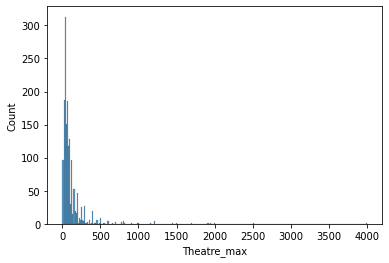

In [9]:
# Plot histogram of Theatre_max with mean values removed
theatre_max_mean = df.loc[0,'Theatre_max']
theatre_max_df = df[df['Theatre_max'] != theatre_max_mean]
sns.histplot(x='Theatre_max', data = theatre_max_df)

<AxesSubplot:xlabel='U-Shaped_max', ylabel='Count'>

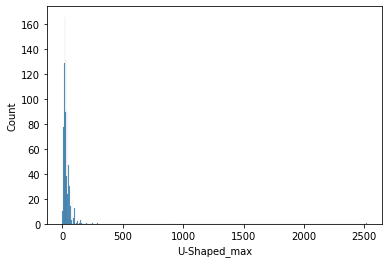

In [10]:
# Plot histogram of U-Shaped_max with mean values removed
u_Shaped_max_mean = df.loc[0,'U-Shaped_max']
u_Shaped_max_df = df[df['U-Shaped_max'] != u_Shaped_max_mean]
sns.histplot(x='U-Shaped_max', data = u_Shaped_max_df)

<b>Note:</b> As you can see from the histogram, the distribution of both features is heavily skewed to the left with few large outliers. As such, the mean values would be better replaced with median values.

In [11]:
# Replace Mean Values with Median Values
theatre_max_median = theatre_max_df['Theatre_max'].median()
df['Theatre_max'].replace(theatre_max_mean,theatre_max_median, inplace=True)

u_Shaped_max_median = u_Shaped_max_df['U-Shaped_max'].median()
df['U-Shaped_max'].replace(u_Shaped_max_mean,u_Shaped_max_median, inplace=True)
#df.head()

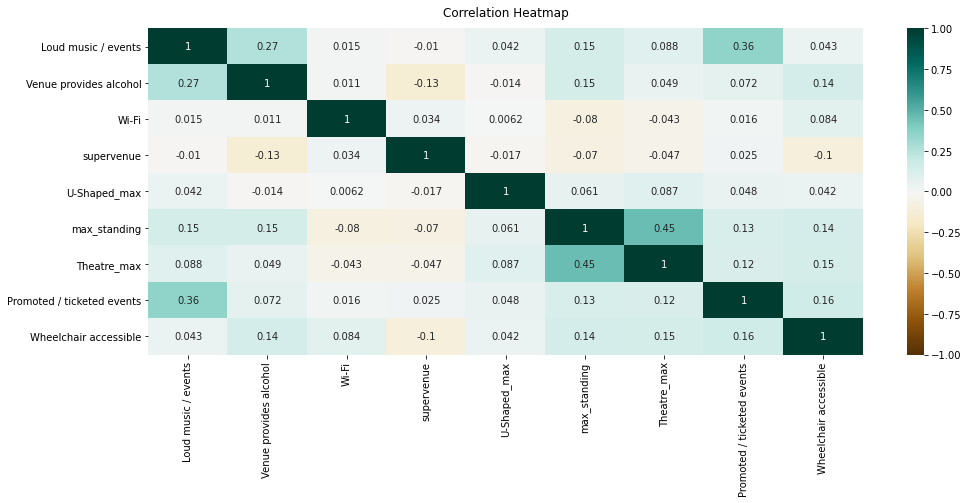

In [12]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


<b>Note:</b> Most features are weakly correlated with the target variable. The top three most correlated are: 'Promoted / ticketed events' (0.16), 'Theatre_max' (0.15), then 'max_standing' and Venue provides alcohol (both 0.14). No features can obviously be discounted, so I will leave them all in.

However, we can drop the 'venue_name' column, as this will have no impact on our target variable so is not needed for the model.

In [13]:
# Drop venue_name column
df.drop('venue_name', axis=1, inplace=True)

<h2> Model Fitting </h2>
In order to build the ML model, I will first split the data into train-test splits.
Then, I will use the ensemble method to test various potential algorithms to see which performs best on the data. Once I have identified the best algorithm, I will tune the parameters using GridSearchCV.


In [14]:
# Split data into train-test split
TARGET_VARIABLE = 'Wheelchair accessible'

X = df.loc[:, df.columns != TARGET_VARIABLE]
y = df[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

In [15]:
# Set up models to test

#Random Forest:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
#Logistic Regression
logreg = LogisticRegression()
#K Nearest Neighbor:
knn = KNeighborsClassifier(n_neighbors = 3) 
# Gaussian Naive Bayes:
gaussian = GaussianNB()
# Perceptron:
perceptron = Perceptron(max_iter=10)
# Support Vector Machine:
svc = SVC()
#Linear Support Vector Machine:
linear_svc = LinearSVC()
 

In [16]:
#Set classifiers for Ensemble Method
classifiers = [('Random Forest',random_forest),
               ('Logistic Regression', logreg), 
               ('K Nearest Neighbours', knn), 
               ('Gaussian Naive Bayes', gaussian), 
               ('Perceptron',perceptron),
               ('Support Vector Machine', svc), 
               ('Linear Support Vector Machine', linear_svc), 
              ]

In [17]:
# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = clf.predict(X_train)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_train) 
   
    # Evaluate clf's accuracy on the training set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))


Random Forest : 0.847
Logistic Regression : 0.626
K Nearest Neighbours : 0.754
Gaussian Naive Bayes : 0.565
Perceptron : 0.510
Support Vector Machine : 0.586
Linear Support Vector Machine : 0.501


<b>Note:</b> As we can see from the above results, the model which performs best on the training data is the Random Forest Classifier. As such, I will tune the hyperparameters using Grid Search Cross Validation.

In [18]:
# Set up parameter grid for tuning
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [19]:
# Run GridsearchCV on esitmator
CV_rfc = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]})

In [20]:
#Extract best parameters
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100}

In [21]:
# Input best params into new classifier
rfc1=RandomForestClassifier(max_features='auto', n_estimators= 100, max_depth=7, criterion='gini')

<h2> Model Evaluation </h2>

Now we have tuned the model, I will evaluate it on the test data, first using the original train-test split, and then confirm using Repeated Stratified Fold Cross Valitadtion for greater accuracy.

In [22]:
# Model evaluation on original split
rfc1.fit(X_train, y_train)
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))


Accuracy for Random Forest on CV data:  0.6666666666666666


In [23]:
# Model evaluation using RepeatedStratifiedKFold Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rfc1, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print(n_scores)
print('The average accuracy over all the folds is %.2f' % np.mean(n_scores))

[0.68797954 0.61636829 0.63171355 0.67519182 0.66240409 0.66496164
 0.70076726 0.69565217 0.69309463 0.65473146 0.68286445 0.70332481
 0.63938619 0.67519182 0.68030691 0.65473146 0.65217391 0.64194373
 0.67774936 0.63682864 0.65984655 0.68542199 0.65473146 0.65217391
 0.70332481 0.70332481 0.64194373 0.65473146 0.65473146 0.60102302]
The average accuracy over all the folds is 0.66


<h2> Results </h2>

As we can see from the model evaluation above, our model has an accuracy of 66%, which means that we will be able to correctly predict the target variable given features 2/3rds of the time, as requested.



<i>"It is a waste of time to contact venues that already have a ramp installed, and it also looks bad for the company. Therefore, it is especially important to exclude locations that already have a ramp. Ideally, at least two-thirds of venues predicted to be without a ramp should not have a ramp."</i>


This model will help the company in reaching out to businesses that are more likely to require installation of wheelchair access.  Without the model, representatives would reach out to the wrong clients 60% of the time, which is a 45% increase in accuracy.


Moving forward, this model could be improved in a number of ways. The most obvious one is to improve the original dataset to fill in what were unknown values in the two max capacity columns we dealt with in the preprocessing stage. If these were accurate values rather than estimates, our model's accuracy would improve. Other than that, we could also increase the number of observations in the dataset, or include more information about each observation if it were feasible to do so.

Now this is developed, the end user (our representatives) will be able to take data from other venues either in London or across the UK and predict which are most likely to require our services. They will also be able to help us improve the model by feeding back any more data that is gained so we can further improve our predictions.